In [1]:
import os
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses, backend, constraints, initializers
from tensorflow.compat.v1.logging import set_verbosity, ERROR
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from scipy.stats import kstest, gaussian_kde, ks_2samp, chi2_contingency, wasserstein_distance
from sdv.metadata import MultiTableMetadata
# from sdv.single_table import CTGANSynthesizer
from sdv.multi_table import HMASynthesizer

In [2]:
set_verbosity(ERROR)

# load data

In [3]:
def load_data_collection(dir_path):
    gtfs_files = [f for f in os.listdir(dir_path) if f.endswith('.csv') or f.endswith('.txt')]
    data_collection = {}
    for f in gtfs_files:
        f_path = os.path.join(dir_path, f)
        data = pd.read_csv(f_path)
        if data.shape[0] > 1:
            data_collection[f.split(".")[0]] = data
    return data_collection

In [4]:
real_data_collection = load_data_collection("gtfs")

In [5]:
del real_data_collection['shapes']

## Create Metadata

In [6]:
def auto_detect_relation(data_collection):
    metadata = {}
    for df_name, df in data_collection.items():
        parent = {}
        child = []
        primary_key = []
        foreign_key = []
        for col in df.columns:
            if 'id' in col:
                if df[col].nunique() == len(df):
                    primary_key = [col, len(df)]
                else:
                    foreign_key.append(col)
        for foreign_df_name, foreign_df in data_collection.items():
            if foreign_df_name != df_name:
                for col in foreign_df.columns:
                    if 'id' in col:
                        for fr_k in foreign_key:
                            if col == fr_k and foreign_df[col].nunique() == len(foreign_df):
                                parent[foreign_df_name] = fr_k
                        if primary_key != []:
                            if col == primary_key[0] and foreign_df[col].nunique() != len(foreign_df):
                                child.append(foreign_df_name)
        metadata[df_name] = {'primary_key':primary_key,
                             'parent':parent,
                             'child':child}
    return metadata

In [7]:
metadata = auto_detect_relation(real_data_collection)

In [8]:
metadata

{'agency': {'primary_key': ['agency_id', 15],
  'parent': {},
  'child': ['routes']},
 'calendar': {'primary_key': ['service_id', 121],
  'parent': {},
  'child': ['calendar_dates', 'trips']},
 'calendar_dates': {'primary_key': [],
  'parent': {'calendar': 'service_id'},
  'child': []},
 'routes': {'primary_key': ['route_id', 215],
  'parent': {'agency': 'agency_id'},
  'child': ['trips']},
 'stops': {'primary_key': ['stop_id', 6714],
  'parent': {},
  'child': ['stop_times']},
 'stop_times': {'primary_key': [],
  'parent': {'stops': 'stop_id', 'trips': 'trip_id'},
  'child': []},
 'trips': {'primary_key': ['trip_id', 32403],
  'parent': {'calendar': 'service_id', 'routes': 'route_id'},
  'child': ['stop_times']}}

In [9]:
# {'agency': {'primary_key': ['agency_id', 15],
#   'parent': {},
#   'child': ['routes']},
#  'calendar': {'primary_key': ['service_id', 121],
#   'parent': {},
#   'child': ['calendar_dates', 'trips']},
#  'calendar_dates': {'primary_key': [],
#   'parent': {'calendar': 'service_id'},
#   'child': []},
#  'routes': {'primary_key': ['route_id', 215],
#   'parent': {'agency': 'agency_id'},
#   'child': ['trips']},
#  'stops': {'primary_key': ['stop_id', 6714],
#   'parent': {},
#   'child': ['stop_times']},
#  'stop_times': {'primary_key': [],
#   'parent': {'stops': 'stop_id', 'trips': 'trip_id'},
#   'child': []},
#  'trips': {'primary_key': ['trip_id', 32403],
#   'parent': {'calendar': 'service_id', 'routes': 'route_id'},
#   'child': ['stop_times']}}

# preprocess

## Create Factorization Dictionary:

In [10]:
def create_factorization_dict(data_collection, metadata):
    factor_dict = {}
    for df_name, df in data_collection.items():
        local_id_dict = {}
        primary_key_info = metadata[df_name]['primary_key']
        if primary_key_info != []:
            local_id_dict = {k:v for v,k in enumerate(df[primary_key_info[0]].unique())}
            factor_dict[primary_key_info[0]] = local_id_dict
    return factor_dict

In [11]:
factorization_dict = create_factorization_dict(real_data_collection, metadata)

## Format Individual Table:

In [12]:
def individual_preprocess_dict():
    preprocess_dict = {}
    preprocess_dict['transformation'] = {}
    preprocess_dict['transformation']['drop'] = []
    preprocess_dict['transformation']['factorize'] = []
    preprocess_dict['transformation']['to_strip'] = []
    preprocess_dict['transformation']['to_elapsed_time'] = []
    preprocess_dict['transformation']['to_elapsed_days'] = []
    preprocess_dict['nans_conversion'] = {}
    preprocess_dict['nans_conversion']['impute'] = []
    preprocess_dict['nans_conversion']['replace_with_neg_one'] = []
    preprocess_dict['nans_conversion']['replace_with_zeros'] = []
    return preprocess_dict

In [13]:
def format_individual_data(data, preprocess_dict, factorization_dict, timestamp = pd.Timestamp('1900-01-01')):
    # reverse_transform_dict = {}
    for stage in preprocess_dict.keys():
        if stage == 'transformation':
            for method, col_list in preprocess_dict[stage].items():
                if len(col_list) != 0 or None:
                    if method == 'drop':
                        data = data.drop(col_list, axis=1)
                    if method == 'factorize':
                        for col in col_list:
                            if col in factorization_dict.keys():
                                data[col] = data[col].map(factorization_dict[col])
                            else:
                                data[col] = pd.factorize(data[col], sort=True)[0]
                    if method == 'to_strip':
                        for col in col_list:
                            # convert some column to numbers
                            # e.g. `123-45-6` -> `123456`
                            data[col] = data[col].str.replace(r'\D', '').astype(int)
                    if method == "to_elapsed_time":
                        for col in col_list:
                            cur_col = pd.to_timedelta(data[col])
                            cur_col = cur_col % pd.Timedelta(days=1)
                            data[col] = cur_col.dt.total_seconds()
                    if method == "to_elapsed_days":
                        for col in col_list:
                            cur_col = pd.to_datetime(data[col], format='%Y%m%d') - timestamp
                            data[col] = cur_col.dt.days
        if stage == 'nans_conversion':
            for method, col_list in preprocess_dict[stage].items():
                if len(col_list) != 0 or None:
                    if method == 'impute':
                        imputer = SimpleImputer(strategy='mean')
                        data[col_list] = imputer.fit_transform(data[col_list])
                    if method == 'replace_with_neg_one':
                        data[col_list] = data[col_list].fillna(-1)
                    if method == 'replace_with_zeros':
                        data[col_list] = data[col_list].fillna(0)
    # scaler = MinMaxScaler(feature_range=(-1, 1))
    # scaled_data = scaler.fit_transform(data)
    return data

## preprocess individual data

In [14]:
sdv_metadata = MultiTableMetadata()

In [15]:
preprocess_dict = individual_preprocess_dict()
preprocess_dict['transformation']['drop'] = ['agency_name','agency_fare_url','agency_email']
preprocess_dict['transformation']['factorize'] = ['agency_id','agency_url','agency_timezone','agency_lang','agency_phone']
real_data_collection['agency'] = format_individual_data(real_data_collection['agency'], preprocess_dict, factorization_dict)

In [16]:
sdv_metadata.detect_table_from_dataframe(table_name='agency', data=real_data_collection['agency'])
sdv_metadata.update_column(table_name='agency',column_name='agency_id',sdtype='id')
sdv_metadata.update_column(table_name='agency',column_name='agency_url',sdtype='categorical')
sdv_metadata.update_column(table_name='agency',column_name='agency_timezone',sdtype='categorical')
sdv_metadata.update_column(table_name='agency',column_name='agency_lang',sdtype='categorical')
sdv_metadata.update_column(table_name='agency',column_name='agency_phone',sdtype='categorical')
sdv_metadata.set_primary_key(table_name='agency',column_name='agency_id')

### calendar

In [17]:
preprocess_dict = individual_preprocess_dict()
preprocess_dict['transformation']['factorize'] = ['service_id']
preprocess_dict['transformation']['to_elapsed_days'] = ['start_date','end_date']
real_data_collection['calendar'] = format_individual_data(real_data_collection['calendar'], preprocess_dict, factorization_dict)

In [18]:
sdv_metadata.detect_table_from_dataframe(table_name='calendar',data=real_data_collection['calendar'])
sdv_metadata.update_column(table_name='calendar',column_name='service_id',sdtype='id')
sdv_metadata.update_column(table_name='calendar',column_name='monday',sdtype='categorical')
sdv_metadata.update_column(table_name='calendar',column_name='tuesday',sdtype='categorical')
sdv_metadata.update_column(table_name='calendar',column_name='wednesday',sdtype='categorical')
sdv_metadata.update_column(table_name='calendar',column_name='thursday',sdtype='categorical')
sdv_metadata.update_column(table_name='calendar',column_name='friday',sdtype='categorical')
sdv_metadata.update_column(table_name='calendar',column_name='saturday',sdtype='categorical')
sdv_metadata.update_column(table_name='calendar',column_name='sunday',sdtype='categorical')
sdv_metadata.update_column(table_name='calendar',column_name='start_date',sdtype='numerical',computer_representation='Int32')
sdv_metadata.update_column(table_name='calendar',column_name='end_date',sdtype='numerical',computer_representation='Int32')
sdv_metadata.set_primary_key(table_name='calendar',column_name='service_id')

### calendar_dates

In [19]:
preprocess_dict = individual_preprocess_dict()
preprocess_dict['transformation']['factorize'] = ['service_id']
preprocess_dict['transformation']['to_elapsed_days'] = ['date']
real_data_collection['calendar_dates'] = format_individual_data(real_data_collection['calendar_dates'], preprocess_dict, factorization_dict)

In [20]:
sdv_metadata.detect_table_from_dataframe(table_name='calendar_dates',data=real_data_collection['calendar_dates'])
sdv_metadata.update_column(table_name='calendar_dates',column_name='service_id',sdtype='id')
sdv_metadata.update_column(table_name='calendar_dates',column_name='date',sdtype='numerical',computer_representation='Int32')
sdv_metadata.update_column(table_name='calendar_dates',column_name='exception_type',sdtype='categorical')

### routes

In [21]:
preprocess_dict = individual_preprocess_dict()
preprocess_dict['transformation']['drop'] = ['route_short_name','route_long_name','route_desc','route_url','route_sort_order']
preprocess_dict['transformation']['factorize'] = ['route_id',
                                                  'agency_id',
                                                 'route_color',
                                                 'route_text_color',
                                                 'contract_id']
preprocess_dict['nans_conversion']['impute'] = ['route_color','route_text_color']
real_data_collection['routes'] = format_individual_data(real_data_collection['routes'], preprocess_dict, factorization_dict)

In [22]:
real_data_collection['routes']['route_color'] = real_data_collection['routes']['route_color'].astype(int)
real_data_collection['routes']['route_text_color'] = real_data_collection['routes']['route_text_color'].astype(int)

In [23]:
sdv_metadata.detect_table_from_dataframe(table_name='routes',data=real_data_collection['routes'])
sdv_metadata.update_column(table_name='routes',column_name='route_id',sdtype='id')
sdv_metadata.update_column(table_name='routes',column_name='agency_id',sdtype='id')
sdv_metadata.update_column(table_name='routes',column_name='route_type',sdtype='categorical')
sdv_metadata.update_column(table_name='routes',column_name='route_color',sdtype='categorical')
sdv_metadata.update_column(table_name='routes',column_name='route_text_color',sdtype='categorical')
sdv_metadata.update_column(table_name='routes',column_name='contract_id',sdtype='id')
sdv_metadata.set_primary_key(table_name='routes',column_name='route_id')

### stops

In [24]:
preprocess_dict = individual_preprocess_dict()
preprocess_dict['transformation']['factorize'] = ['stop_id','parent_station','platform_code']
preprocess_dict['transformation']['to_elapsed_days'] = ['start_date','end_date']
preprocess_dict['transformation']['drop'] = ['stop_name','stop_code','stop_desc','zone_id','stop_url','stop_timezone']
preprocess_dict['nans_conversion']['impute'] = ['parent_station','platform_code']
real_data_collection['stops'] = format_individual_data(real_data_collection['stops'], preprocess_dict, factorization_dict)

In [25]:
real_data_collection['stops']['parent_station'] = real_data_collection['stops']['parent_station'].astype(int)
real_data_collection['stops']['platform_code'] = real_data_collection['stops']['platform_code'].astype(int)

In [26]:
sdv_metadata.detect_table_from_dataframe(table_name='stops',data=real_data_collection['stops'])
sdv_metadata.update_column(table_name='stops',column_name='stop_id',sdtype='id')
sdv_metadata.update_column(table_name='stops',column_name='stop_lat',sdtype='numerical',computer_representation='Float')
sdv_metadata.update_column(table_name='stops',column_name='stop_lon',sdtype='numerical',computer_representation='Float')
sdv_metadata.update_column(table_name='stops',column_name='location_type',sdtype='categorical')
sdv_metadata.update_column(table_name='stops',column_name='parent_station',sdtype='categorical')
sdv_metadata.update_column(table_name='stops',column_name='platform_code',sdtype='categorical')
sdv_metadata.update_column(table_name='stops',column_name='wheelchair_boarding',sdtype='categorical')
sdv_metadata.update_column(table_name='stops',column_name='start_date',sdtype='numerical',computer_representation='Int32')
sdv_metadata.update_column(table_name='stops',column_name='end_date',sdtype='numerical',computer_representation='Int32')
sdv_metadata.set_primary_key(table_name='stops',column_name='stop_id')

### stop_times

In [27]:
preprocess_dict = individual_preprocess_dict()
preprocess_dict['transformation']['factorize'] = ['trip_id','stop_id','stop_headsign']
preprocess_dict['transformation']['to_elapsed_time'] = ['arrival_time','departure_time']
real_data_collection['stop_times'] = format_individual_data(real_data_collection['stop_times'], preprocess_dict, factorization_dict)

In [28]:
real_data_collection['stop_times']['arrival_time'] = real_data_collection['stop_times']['arrival_time'].astype(int)
real_data_collection['stop_times']['departure_time'] = real_data_collection['stop_times']['departure_time'].astype(int)

In [29]:
sdv_metadata.detect_table_from_dataframe(table_name='stop_times',data=real_data_collection['stop_times'])
sdv_metadata.update_column(table_name='stop_times',column_name='trip_id',sdtype='id')
sdv_metadata.update_column(table_name='stop_times',column_name='arrival_time',sdtype='numerical',computer_representation='Int32')
sdv_metadata.update_column(table_name='stop_times',column_name='departure_time',sdtype='numerical',computer_representation='Int32')
sdv_metadata.update_column(table_name='stop_times',column_name='stop_id',sdtype='id')
sdv_metadata.update_column(table_name='stop_times',column_name='stop_sequence',sdtype='categorical')
sdv_metadata.update_column(table_name='stop_times',column_name='stop_headsign',sdtype='categorical')
sdv_metadata.update_column(table_name='stop_times',column_name='pickup_type',sdtype='categorical')
sdv_metadata.update_column(table_name='stop_times',column_name='drop_off_type',sdtype='categorical')
sdv_metadata.update_column(table_name='stop_times',column_name='shape_dist_traveled',sdtype='numerical',computer_representation='Float')
sdv_metadata.update_column(table_name='stop_times',column_name='timepoint',sdtype='categorical')

### trips

In [30]:
preprocess_dict = individual_preprocess_dict()
preprocess_dict['transformation']['factorize'] = ['route_id','service_id','trip_id','trip_headsign','shape_id']
preprocess_dict['transformation']['drop'] = ['trip_short_name','block_id']
real_data_collection['trips'] = format_individual_data(real_data_collection['trips'], preprocess_dict, factorization_dict)

In [31]:
sdv_metadata.detect_table_from_dataframe(table_name='trips',data=real_data_collection['trips'])
sdv_metadata.update_column(table_name='trips',column_name='route_id',sdtype='id')
sdv_metadata.update_column(table_name='trips',column_name='service_id',sdtype='id')
sdv_metadata.update_column(table_name='trips',column_name='trip_id',sdtype='id')
sdv_metadata.update_column(table_name='trips',column_name='trip_headsign',sdtype='categorical')
sdv_metadata.update_column(table_name='trips',column_name='direction_id',sdtype='id')
sdv_metadata.update_column(table_name='trips',column_name='shape_id',sdtype='id')
sdv_metadata.update_column(table_name='trips',column_name='wheelchair_accessible',sdtype='categorical')
sdv_metadata.update_column(table_name='trips',column_name='bikes_allowed',sdtype='categorical')
sdv_metadata.set_primary_key(table_name='trips',column_name='trip_id')

## Add SDV Relations

In [32]:
sdv_metadata.add_relationship(
    parent_table_name='agency',
    child_table_name='routes',
    parent_primary_key='agency_id',
    child_foreign_key='agency_id'
)

sdv_metadata.add_relationship(
    parent_table_name='calendar',
    child_table_name='calendar_dates',
    parent_primary_key='service_id',
    child_foreign_key='service_id'
)

sdv_metadata.add_relationship(
    parent_table_name='calendar',
    child_table_name='trips',
    parent_primary_key='service_id',
    child_foreign_key='service_id'
)

sdv_metadata.add_relationship(
    parent_table_name='routes',
    child_table_name='trips',
    parent_primary_key='route_id',
    child_foreign_key='route_id'
)

sdv_metadata.add_relationship(
    parent_table_name='stops',
    child_table_name='stop_times',
    parent_primary_key='stop_id',
    child_foreign_key='stop_id'
)

sdv_metadata.add_relationship(
    parent_table_name='trips',
    child_table_name='stop_times',
    parent_primary_key='trip_id',
    child_foreign_key='trip_id'
)

In [33]:
sdv_metadata.relationships

[{'parent_table_name': 'agency',
  'child_table_name': 'routes',
  'parent_primary_key': 'agency_id',
  'child_foreign_key': 'agency_id'},
 {'parent_table_name': 'calendar',
  'child_table_name': 'calendar_dates',
  'parent_primary_key': 'service_id',
  'child_foreign_key': 'service_id'},
 {'parent_table_name': 'calendar',
  'child_table_name': 'trips',
  'parent_primary_key': 'service_id',
  'child_foreign_key': 'service_id'},
 {'parent_table_name': 'routes',
  'child_table_name': 'trips',
  'parent_primary_key': 'route_id',
  'child_foreign_key': 'route_id'},
 {'parent_table_name': 'stops',
  'child_table_name': 'stop_times',
  'parent_primary_key': 'stop_id',
  'child_foreign_key': 'stop_id'},
 {'parent_table_name': 'trips',
  'child_table_name': 'stop_times',
  'parent_primary_key': 'trip_id',
  'child_foreign_key': 'trip_id'}]

## Visualize Collection

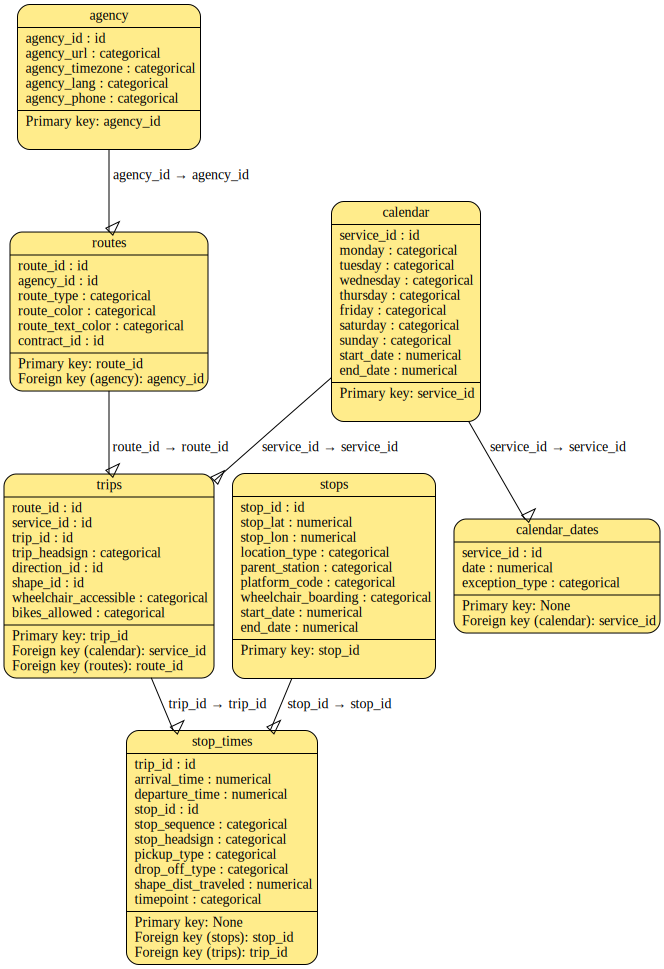

In [34]:
sdv_metadata.visualize(
    show_table_details=True,
    show_relationship_labels=True,
    output_filepath='my_metadata.png'
)

## Validate Collection Integrity

In [35]:
sdv_metadata.validate()

# Modeling

In [36]:
synthesizer = HMASynthesizer(sdv_metadata)
synthesizer.save(
    filepath='models/gtfs.pkl'
)

In [ ]:
synthesizer.fit(real_data_collection)

C:\programs\conda\envs\tfgpu\lib\site-packages\copulas\multivariate\gaussian.py:280: DeprecationWarning: `covariance` will be renamed to `correlation` in v0.4.0
  warnings.warn('`covariance` will be renamed to `correlation` in v0.4.0',
C:\programs\conda\envs\tfgpu\lib\site-packages\copulas\multivariate\gaussian.py:280: DeprecationWarning: `covariance` will be renamed to `correlation` in v0.4.0
  warnings.warn('`covariance` will be renamed to `correlation` in v0.4.0',
C:\programs\conda\envs\tfgpu\lib\site-packages\copulas\multivariate\gaussian.py:280: DeprecationWarning: `covariance` will be renamed to `correlation` in v0.4.0
  warnings.warn('`covariance` will be renamed to `correlation` in v0.4.0',
C:\programs\conda\envs\tfgpu\lib\site-packages\copulas\multivariate\gaussian.py:280: DeprecationWarning: `covariance` will be renamed to `correlation` in v0.4.0
  warnings.warn('`covariance` will be renamed to `correlation` in v0.4.0',
C:\programs\conda\envs\tfgpu\lib\site-packages\copulas\m

In [ ]:
synthetic_data = synthesizer.sample(100)